The goal is to build a CNN model using PyTorch and train it on the <a href='https://www.kaggle.com/zalando-research/fashionmnist'>Fashion-MNIST</a> dataset. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes:<br>

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=transform)

100.0%


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


100.0%


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




19.3%

100.0%
100.0%


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']

In [5]:
# create data loaders
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

Label:  [9 2 4 7 4 5 3 4 7 5]
Class:  Boot Sweater Coat Sneaker Coat Sandal Dress Coat Sneaker Sandal


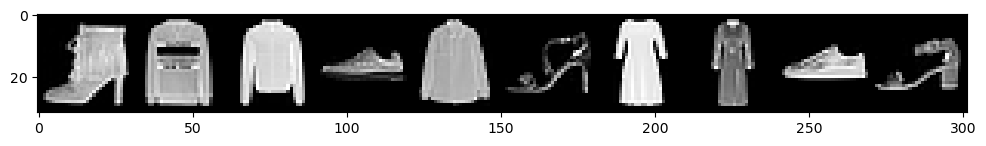

In [6]:
# examine a batch of images
for images,labels in train_loader: 
    break

print('Label: ', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=10)
plt.figure(figsize=(12,4))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [7]:
# define a CNN model
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [9]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [10]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# train the model
import time
start_time = time.time()

epochs = 5

for i in range(epochs):
    for X_train, y_train in train_loader:

        # apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'{i+1} of {epochs} epochs completed')

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

1 of 5 epochs completed
2 of 5 epochs completed
3 of 5 epochs completed
4 of 5 epochs completed
5 of 5 epochs completed

Duration: 105 seconds


In [12]:
# evaluate the model
model.eval()

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_loader:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 8970/10000 =  89.700%
